In [61]:
"""
移動平均線や大陽線のデータから翌日陽線になるか予測するモデル作成
元notebook: C:/Users/shingo/jupyter_notebook/stock_work/work/tmp.ipynb
Usage:
    # make_stock_csv.py してstock_rate_2008_2018.csv がカレントディレクトリにある状態からスタート
    $ docker run -p 8888:8888 -it -v $PWD/jupyter_notebook:/jupyter_notebook --rm --entrypoint /bin/bash --name pycaret_jupyterlab anarinsk/pycaret_jupyterlab:1.0.0  # コンテナ起動してbashで入る
    $ jupyter lab --ip=0.0.0.0 --allow-root --LabApp.token=''  # jupyter lab起動して実行
    ※pycaretはpythonモジュールから実行できない
"""
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
np.random.seed(7)
random.seed(7)
%matplotlib inline

from pycaret.classification import *
#from pycaret.regression import *  # 回帰の場合はこっち


def load_df(csv_path='stock_rate_2008_2018.csv'):
    """ csvからデータロード """
    df_concat = pd.read_csv(csv_path)
    # df = df_concat[:2000]
    df = df_concat[:70000]
    # df = df_concat[:df_concat.shape[0]//10]

    # posi/negaの数同じにしておく
    df_posi = df[df['next_close_oepn_rate'] >= 1.0]
    df_nega = df[df['next_close_oepn_rate'] < 1.0]
    n_count = df_nega.shape[0] if df_posi.shape[0] > df_nega.shape[0] else df_posi.shape[0]
    df = pd.concat([df_posi[:n_count], df_nega[:n_count]], ignore_index=True).sample(frac=1)

    # 2値化 回帰だと全て1.0未満と予測してうまくいかなかったので分類モデルにする
    df['next_close_oepn_rate'] = np.where(df['next_close_oepn_rate'] >= 1.0, 1, 0)
    df['next_close_oepn_rate'] = df['next_close_oepn_rate'].astype('int')

    return df_concat, df


def load_class_model(pkl_name):
    """ pycaretのモデルロード """
    pkl = load_model(pkl_name)  # 拡張子なしのpklファイル
    return pkl[1]  # リストになっていて1番目がモデル本体

    
def eval_binary_class_model(model, df):
    """ 2値分類のモデル評価 """
    X = df[['5MA_div_rate', '25MA_div_rate', '75MA_div_rate', '200MA_div_rate',
            '10MAX_div_rate', 'volume_1diff_rate', 'candlestick']]
    df_pred = predict_model(model, X)
    
    df_pred['true'] = df['next_close_oepn_rate'].apply(lambda x: 1 if x >= 1.0 else 0).to_list()

    df_pred['match'] = df_pred.apply(lambda row: 1 if row['Label'] == row['true'] else 0, axis=1)
    # display(df_pred)

    n_match = int(df_pred[df_pred['match'] == 1].shape[0])
    print('正解率:', n_match / int(df_pred.shape[0]))

    # 混同行列
    sns.heatmap(confusion_matrix(df_pred['true'], df_pred['Label']),
                annot=True, fmt="d", cbar=False)

In [2]:
# if __name__ == '__main__':

# データロード
df_all, train_df = load_df()

# pycaretにデータをセットする
exp1 = setup(train_df, target='next_close_oepn_rate')  # Enterキー2回押す必要あり

 
Setup Succesfully Completed!


,Description,Value
0,session_id,5455
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(65894, 8)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [3]:
# 指定モデルでパラメチューニングしてpklで保存
tuned_lightgbm = tune_model('lightgbm')
save_model(tuned_lightgbm, model_name='tuned_lightgbm_class')

# モデルアンサンブル
tuned_et = tune_model('et')  # Extra Trees Classifier
tuned_xgboost = tune_model('xgboost')
ensemble_cla = blend_models([tuned_et, tuned_xgboost, tuned_lightgbm])
holdout_pred = predict_model(ensemble_cla)
save_model(ensemble_cla, model_name='ensemble_cla')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Voting Classifier,0.5344,0,0.5199,0.5354,0.5275,0.0687


Transformation Pipeline and Model Succesfully Saved


正解率: 0.5


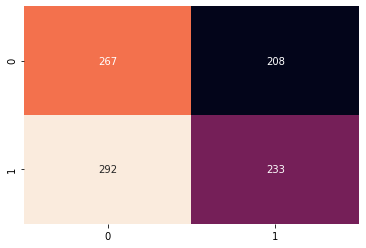

In [62]:
# 1000件テスト
test_df = df_all[df_all.shape[0] // 10: df_all.shape[0] // 10 + 1000]
eval_binary_class_model(tuned_lightgbm, test_df)

正解率: 0.487


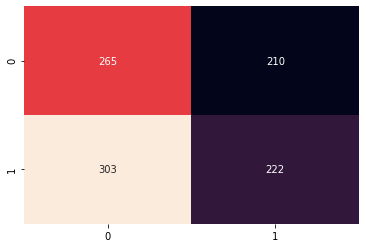

In [63]:
eval_binary_class_model(ensemble_cla, test_df)

In [60]:
X = test_df[['5MA_div_rate', '25MA_div_rate', '75MA_div_rate', '200MA_div_rate', '10MAX_div_rate', 'volume_1diff_rate', 'candlestick']]
predict_model(tuned_lightgbm, X)

,5MA_div_rate,25MA_div_rate,75MA_div_rate,200MA_div_rate,10MAX_div_rate,volume_1diff_rate,candlestick,Label,Score
0,0.022622,-0.050253,-0.232519,-0.378912,0.948608,0.516129,-0.750000,1,0.5323
1,0.036793,-0.017223,-0.203436,-0.357899,0.977516,0.261905,1.000000,0,0.4001
2,0.036368,0.002893,-0.183675,-0.344635,0.994647,0.160000,0.000000,0,0.2449
3,0.023778,0.007017,-0.176991,-0.342049,0.995717,0.565217,-0.066667,0,0.2961
4,0.023913,0.023379,-0.160647,-0.331678,1.008565,0.160584,0.088889,0,0.4888
...,...,...,...,...,...,...,...,...,...
995,0.020912,0.055278,0.106818,0.172352,0.981921,-0.102484,0.057143,0,0.4519
996,0.011628,0.053473,0.105052,0.172594,0.983051,-0.677083,0.000000,0,0.4349
997,0.003001,0.047240,0.100687,0.170158,0.981921,-0.476923,-0.250000,0,0.4519
998,0.008268,0.053111,0.109370,0.181124,0.992090,0.380952,0.458333,0,0.4936


In [59]:
X = test_df[['5MA_div_rate', '25MA_div_rate', '75MA_div_rate', '200MA_div_rate', '10MAX_div_rate', 'volume_1diff_rate', 'candlestick']]
predict_model(ensemble_cla, X)

,5MA_div_rate,25MA_div_rate,75MA_div_rate,200MA_div_rate,10MAX_div_rate,volume_1diff_rate,candlestick,Label
0,0.022622,-0.050253,-0.232519,-0.378912,0.948608,0.516129,-0.750000,0
1,0.036793,-0.017223,-0.203436,-0.357899,0.977516,0.261905,1.000000,0
2,0.036368,0.002893,-0.183675,-0.344635,0.994647,0.160000,0.000000,1
3,0.023778,0.007017,-0.176991,-0.342049,0.995717,0.565217,-0.066667,1
4,0.023913,0.023379,-0.160647,-0.331678,1.008565,0.160584,0.088889,0
...,...,...,...,...,...,...,...,...
995,0.020912,0.055278,0.106818,0.172352,0.981921,-0.102484,0.057143,0
996,0.011628,0.053473,0.105052,0.172594,0.983051,-0.677083,0.000000,0
997,0.003001,0.047240,0.100687,0.170158,0.981921,-0.476923,-0.250000,0
998,0.008268,0.053111,0.109370,0.181124,0.992090,0.380952,0.458333,0


In [ ]:
def eval_binary_class_model_old(model, df):
    """ 2値分類のモデル評価 """
    X = df[['5MA_div_rate', '25MA_div_rate', '75MA_div_rate', '200MA_div_rate',
            '10MAX_div_rate', 'volume_1diff_rate', 'candlestick']].values
    # print(X)

    preds = model.predict(X)
    print(preds)
    onehot_preds = [1 if p >= 0.5 else 0 for p in preds]
    print(onehot_preds)

    trues = df['next_close_oepn_rate'].apply(lambda x: 1 if x >= 1.0 else 0).to_list()
    df_pred = pd.DataFrame([onehot_preds, trues]).T
    df_pred.columns = ['pred', 'true']
    df_pred['match'] = df_pred.apply(lambda row: 1 if row[0] == row[1] else 0, axis=1)

    n_match = int(df_pred[df_pred['match'] == 1].shape[0])
    print('正解率:', n_match / int(df_pred.shape[0]))

    # 混同行列
    sns.heatmap(confusion_matrix(df_pred['true'], df_pred['pred']),
                annot=True, fmt="d", cbar=False)

In [12]:
help(predict_model)

Help on function predict_model in module pycaret.classification:

predict_model(estimator, data=None, probability_threshold=None, platform=None, authentication=None)
    Description:
    ------------
    This function is used to predict new data using a trained estimator. It accepts
    an estimator created using one of the function in pycaret that returns a trained 
    model object or a list of trained model objects created using stack_models() or 
    create_stacknet(). New unseen data can be passed to data param as pandas Dataframe. 
    If data is not passed, the test / hold-out set separated at the time of setup() is
    used to generate predictions. 
    
        Example:
        --------
        from pycaret.datasets import get_data
        juice = get_data('juice')
        experiment_name = setup(data = juice,  target = 'Purchase')
        lr = create_model('lr')
        
        lr_predictions_holdout = predict_model(lr)
        
    Parameters
    ----------
    estimator : 